In [31]:
import requests
import json
import time
import pandas as pd
headers = {"accept": "application/json"}

In [32]:
#read the json file and grab the api-root and api-key
with open('api_config.json') as f:
    data = json.load(f)
    api_root = data['api-root']
    api_key = data['api-key']

In [ ]:
#first grabbing the league heirarchy to get our two teams of interest (Lakers and Timberwolves)
url = api_root + '/league/hierarchy.json?api_key=' + api_key
print(url)
response = requests.get(url, headers=headers)
print(response.status_code)
if response.status_code == 200:
    print("Success")
    league_string = response.text
    league_heirarchy = json.loads(league_string)
#save json to file
with open('league_heirarchy.json', 'w') as f:
    json.dump(league_heirarchy, f, indent=4)

In [ ]:
#for the ease of use, lets convert our league heigharchy to a dataframe where each row is a team
import pandas as pd
teams = []
#the headers of the dataframe are as follows, conference, division, teamName, teamId, teamCity
df = pd.DataFrame(columns=['conference', 'division', 'teamName', 'teamId', 'teamCity'])
for conference in league_heirarchy['conferences']:
    for division in conference['divisions']:
        for team in division['teams']:
            teams.append([conference['name'], division['name'], team['name'], team['id'], team['market']])
df = pd.DataFrame(teams, columns=['conference', 'division', 'teamName', 'teamId', 'teamCity'])
#save df to csv
df.to_csv('league_heirarchy.csv', index=False)

In [ ]:
#Inside of the dataframe, we can now filter for the Lakers and Timberwolves and grab their teamId
df = pd.read_csv('league_heirarchy.csv')
lakers_id = df[df['teamName'] == 'Lakers']['teamId'].item()
cavs_id = df[df['teamName'] == 'Cavaliers']['teamId'].item()
print("Lakers ID: " + lakers_id)
print("Cavaliers ID: " + cavs_id)

In [ ]:
#list of teams in league_heirarchy
teams = df['teamId'].tolist()
teams = list(set(teams))
print(len(teams))

In [ ]:
id = '583eca2f-fb46-11e1-82cb-f4ce4684ea4c'
name = df[df['teamId'] == id]['teamName'].item()
print(name)

In [ ]:
#Now that we have the team ids, we can grab the team stats
#Notice I am only grabbing from 2018 onwards for the statistics
#I believe this may project better as we are only considering the "Lebron James era" in LA
#2024 season has not started yet, so no need to grab that data
nba_team_stats = pd.DataFrame()
nba_players = pd.DataFrame()
for year in range(2014, 2018):
    print(year)
    for team in teams:
        url = api_root + '/seasons/{year}/REG/teams/{team_id}/statistics.json?api_key={api_key}'.format(year=year, team_id=team, api_key=api_key)
        #print team that corresponds to team_id
        team_name = df[df['teamId'] == team]['teamName'].item()
        response = requests.get(url, headers=headers)
        print(f"Team: {team_name}" + "Response:" + str(response.status_code))
        if response.status_code == 200:
            print("Success")
            team_string = response.text
            team_stats = json.loads(team_string)
            team_stats_df = pd.json_normalize(team_stats)
            team_stats_df['teamId'] = team
            nba_team_stats = pd.concat([nba_team_stats, team_stats_df])
            nba_team_stats = nba_team_stats.drop(columns=['players'])
            if 'players' in team_stats_df.columns:
                for player in team_stats['players']:
                    player_df = pd.json_normalize(player)
                    #add team and year to the player dataframe
                    player_df['teamId'] = team
                    player_df['year'] = year
                    player_df['teamName'] = team_stats['name']
                    nba_players = pd.concat([nba_players, player_df])
        time.sleep(2)
nba_team_stats.to_csv('nba_team_stats2014-2017.csv', index=False)
nba_players.to_csv('nba_players2014-2017.csv', index=False)
    

                                  

In [ ]:
nba_schedule = pd.DataFrame()
games_list = []
for year in range(2014, 2018):
    url = api_root + '/games/{year}/REG/schedule.json?api_key={api_key}'.format(year=year, api_key=api_key)
    response = requests.get(url, headers=headers)
    print(f"Year: {year}" + "Response:" + str(response.status_code))
    if response.status_code == 200:
        print("Success")
        schedule_string = response.text
        schedule = json.loads(schedule_string)
        for game in schedule['games']:
            game_year = schedule['season']['year']
            game_id = game['id']
            game_date = game['scheduled']
            game_home_team = game['home']['id']
            game_away_team = game['away']['id']
            game_home_name = game['home']['name']
            game_away_name = game['away']['name']
            if game['status'] != 'postponed' and game['status'] != 'cancelled':
                game_home_pts = game['home_points']
                game_away_pts = game['away_points']
                games_list.append([game_year, game_id, game_date, game_home_team, game_away_team, game_home_name, game_away_name, game_home_pts, game_away_pts])
            else:
                pass
    time.sleep(2)
    
nba_schedule = pd.DataFrame(games_list, columns=['year', 'game_id', 'game_date', 'home_team', 'away_team', 'home_name', 'away_name', 'home_pts', 'away_pts'])

In [70]:
#now a list of only the games the Los Angeles Lakers played in
lakers_schedule = nba_schedule[(nba_schedule['home_team'] == lakers_id) | (nba_schedule['away_team'] == lakers_id)]
lakers_schedule.to_csv('lakers_schedule.csv', index=False)

In [27]:
#games the cavaliers played in from 2014-2017
cavaliers_schedule = nba_schedule[(nba_schedule['home_team'] == cavs_id) | (nba_schedule['away_team'] == cavs_id)]
cavaliers_schedule.to_csv('cavaliers_schedule2014-2017.csv', index=False)

In [28]:
nba_schedule.to_csv('nba_schedule2014-2018.csv', index=False)

In [ ]:
#now we want Lebron's Stats from 2018 onwards
cavs_schedule = pd.read_csv('cavaliers_schedule2014-2017.csv')
cavs_games = cavs_schedule['game_id'].tolist()
LeStats = pd.DataFrame()
LeStats_list = []
for game in cavs_games:
    url = api_root + '/games/{game_id}/summary.json?api_key={api_key}'.format(game_id=game, api_key=api_key)
    response = requests.get(url, headers=headers)
    print("Response:" + str(response.status_code))
    if response.status_code == 200:
        print("Success")
        game_string = response.text
        game = json.loads(game_string)
        print(game)
        home_team_name = game['home']['name']
        game_home_pts = game['home']['points']
        away_team_name = game['away']['name']
        game_away_pts = game['away']['points']
        year = game['scheduled']
        print(year)
        #figure out which team is the lakers
        if home_team_name == 'Cavaliers':
            #find Lebron's stats
            for player in game['home']['players']:
                if player['full_name'] == 'LeBron James':
                    #add team and year to the player
                    player['team'] = home_team_name
                    player['opp'] = away_team_name
                    player['year'] = year
                    player['home_pts'] = game_home_pts
                    player['away_pts'] = game_away_pts
                    player['W/L'] = 'W' if game_home_pts > game_away_pts else 'L'
                    LeStats_list.append(player)
        else:
            for player in game['away']['players']:
                if player['full_name'] == 'LeBron James':
                    #add team and year to the player
                    player['team'] = away_team_name
                    player['opp'] = home_team_name
                    player['year'] = year
                    player['home_pts'] = game_home_pts
                    player['away_pts'] = game_away_pts
                    player['W/L'] = 'W' if game_home_pts > game_away_pts else 'L'
                    LeStats_list.append(player)
                    
    time.sleep(2)
LeStats = pd.json_normalize(LeStats_list)
LeStats = LeStats.drop(columns=['statistics.periods'])
LeStats.to_csv('LebronStats2014-2017.csv', index=False)

In [ ]:
#now we want Lebron's Stats from 2018 onwards
lakers_schedule = pd.read_csv('lakers_schedule.csv')
lakers_games = lakers_schedule['game_id'].tolist()
LeStats = pd.DataFrame()
LeStats_list = []
for game in lakers_games:
    url = api_root + '/games/{game_id}/summary.json?api_key={api_key}'.format(game_id=game, api_key=api_key)
    response = requests.get(url, headers=headers)
    print("Response:" + str(response.status_code))
    if response.status_code == 200:
        print("Success")
        game_string = response.text
        game = json.loads(game_string)
        print(game)
        home_team_name = game['home']['name']
        game_home_pts = game['home']['points']
        away_team_name = game['away']['name']
        game_away_pts = game['away']['points']
        year = game['scheduled']
        print(year)
        #figure out which team is the lakers
        if home_team_name == 'Lakers':
            #find Lebron's stats
            for player in game['home']['players']:
                if player['full_name'] == 'LeBron James':
                    #add team and year to the player
                    player['team'] = home_team_name
                    player['opp'] = away_team_name
                    player['year'] = year
                    player['home_pts'] = game_home_pts
                    player['away_pts'] = game_away_pts
                    player['W/L'] = 'W' if game_home_pts > game_away_pts else 'L'
                    LeStats_list.append(player)
        else:
            for player in game['away']['players']:
                if player['full_name'] == 'LeBron James':
                    #add team and year to the player
                    player['team'] = away_team_name
                    player['opp'] = home_team_name
                    player['year'] = year
                    player['home_pts'] = game_home_pts
                    player['away_pts'] = game_away_pts
                    player['W/L'] = 'W' if game_home_pts > game_away_pts else 'L'
                    LeStats_list.append(player)
                    
    time.sleep(2)
LeStats = pd.json_normalize(LeStats_list)
LeStats = LeStats.drop(columns=['statistics.periods'])
LeStats.to_csv('LebronStats.csv', index=False)

# Data Transformation

In [257]:
import numpy as np
LeStats = pd.read_csv('LebronStats.csv')
LeStats = pd.concat([LeStats, pd.read_csv('LebronStats2014-2017.csv')])
#Drop all rows where Lebron did not play
#drop rows where injury column is not null
print(LeStats.shape)
LeStats['injuries'] = LeStats['injuries'].fillna('healthy')
LeStats = LeStats[LeStats['injuries'] == 'healthy']
print(LeStats.shape)
#drop injury column
LeStats = LeStats.drop(columns=['injuries'])
#drop columns with NaN values
print(LeStats.shape)
print(LeStats.shape)
#for the played column if it is empty, fill with False
LeStats['played'] = LeStats['played'].fillna(False)
LeStats = LeStats[LeStats['played'] == True]
LeStats['year'] = pd.to_datetime(LeStats['year'])
LeStats = LeStats.sort_values(by='year')
LeStats['date'] = LeStats['year']
LeStats['year'] = LeStats['year'].dt.year
LeStats['day'] = LeStats['date'].dt.day
LeStats['month'] = LeStats['date'].dt.month


(631, 86)
(618, 86)
(618, 85)
(618, 85)


C:\Users\pnihr\AppData\Local\Temp\ipykernel_44240\4170898893.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  LeStats['played'] = LeStats['played'].fillna(False)


In [258]:
#new feature for days rest between games, for start of new season (greater than 30 days), we will assume median days rest
LeStats['days_rest'] = LeStats['date'].diff().dt.days
median = LeStats['days_rest'].median()
LeStats['days_rest'] = LeStats['days_rest'].fillna(median)
LeStats['days_rest'] = LeStats['days_rest'].astype(int)
LeStats['days_rest'] = LeStats['days_rest'].apply(lambda x: median if x > 30 else x)
LeStats['days_rest']

0      2.0
1      4.0
2      0.0
3      2.0
4      6.0
      ... 
465    1.0
466    2.0
468    3.0
469    2.0
470    1.0
Name: days_rest, Length: 485, dtype: float64

In [259]:
#Encode True and False to 1 and 0
LeStats = LeStats.replace({'true': 1, 'false': 0})
#label encode primary position to numerical
positions = {'C': 5, 'PF': 4, 'PG': 1, 'SF': 3, 'SG': 2}
LeStats['primary_position'] = LeStats['primary_position'].map(positions)
LeStats['primary_position']
#Indicate if Lebron is home or away if home scored more points and is marked at lebron win or if home scored less points and is marked as lebron loss then 1 else 0
LeStats['home/away'] = LeStats.apply(lambda x: 1 if (x['W/L'] == 'W' and x['home_pts'] > x['away_pts']) or (x['W/L'] != 'L' and x['home_pts'] < x['away_pts']) else 0, axis=1)

C:\Users\pnihr\AppData\Local\Temp\ipykernel_44240\4161733679.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  LeStats = LeStats.replace({'true': 1, 'false': 0})


In [260]:
nba_team_stats = pd.read_csv('nba_team_stats.csv')
#Add a new column that displays the orating drating of the opposing team in the year the game was played
LeStats['opp_points_against_avg'] = 0
LeStats['opp_drebounds_avg'] = 0
LeStats['opp_blocks_avg'] = 0
LeStats['opp_steals_avg'] = 0
LeStats['opp_fgm_against_avg'] = 0

#vectorized operation to fill in the opp_orating and opp_drating columns
def fill_orating_drating(row):
    #convert year which is datetime object to the year only
    year = row['year']
    print(year)
    team = row['opp']
    if year == 2024:
        year = 2023
    points_against = nba_team_stats[(nba_team_stats['season.year'] == year) & (nba_team_stats['name'] == team)]['opponents.average.points']
    field_goal_against = nba_team_stats[(nba_team_stats['season.year'] == year) & (nba_team_stats['name'] == team)]['opponents.average.field_goals_made']
    blocks = nba_team_stats[(nba_team_stats['season.year'] == year) & (nba_team_stats['name'] == team)]['own_record.average.blocks']
    steals = nba_team_stats[(nba_team_stats['season.year'] == year) & (nba_team_stats['name'] == team)]['own_record.average.steals']
    drebounds = nba_team_stats[(nba_team_stats['season.year'] == year) & (nba_team_stats['name'] == team)]['own_record.average.def_rebounds']
    if not points_against.empty:
        row['opp_point_agains_avg'] = points_against.item()
    if not field_goal_against.empty:
        row['opp_drating'] = field_goal_against.item()
    if not blocks.empty:
        row['opp_blocks_avg'] = blocks.item()
    if not steals.empty:
        row['opp_steals_avg'] = steals.item()
    if not drebounds.empty:
        row['opp_drebounds_avg'] = drebounds.item()
    return row

LeStats = LeStats.apply(fill_orating_drating, axis=1)

2014
2014
2014
2014
2014
2014
2014
2014
2014
2014
2014
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019


Label Encoding Might Be The Best Way to Do This, trying with One-Hot encoding first

In [261]:
from sklearn.preprocessing import LabelEncoder
LeStats['opp'] = LabelEncoder().fit_transform(LeStats['opp'])
LeStats['team'] = LabelEncoder().fit_transform(LeStats['team'])

In [262]:
#minutes to be converted to decimal
LeStats['statistics.minutes'] = LeStats['statistics.minutes'].str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)

Rolling Average will give us some features to work with that can be used to predict games we only are given a few pieces of information about (Date, Opponent, Location)

In [263]:
#New row in the stats dataframe that gives a previous 5 game average of the player's stats
#Ultimately we are still going to have to wittle down the features even more but this will give a decent idea
#Of which features are important
#list of all columns starting with statistics
cols = LeStats.columns
stats_cols = [col for col in cols if 'statistics' in col]
numerical_LeStats = LeStats.copy()
#add a new column that gives the 5 game average of each of the statistics columns
for col in stats_cols:
    #eliminate statistrics. part of the column name
    col_name = col.split('.')[1]
    numerical_LeStats[col_name + '_5gavg'] = numerical_LeStats.groupby('team')[col].transform(lambda x: x.rolling(5, 1).mean())

In [264]:
#Any data we can not reasonably infer from previous data points must be dropped 
#(ex. we can't know exactly how many rebounds he will have in the game we are predicting so its not a helpful feature)
#(This is what makes rolling averages so powerful, we can infer future performance based on past performance in the context of the player's career)
numerical_LeStats = numerical_LeStats.drop(columns=['full_name', 
                                          'jersey_number',
                                          'first_name',
                                          'last_name',
                                          'position',
                                          'id',
                                          'played',
                                          'active',
                                          'starter',
                                          'on_court',
                                          'sr_id',
                                          'reference',
                                          'home_pts', 
                                          'away_pts', 
                                          'W/L',
                                          'statistics.minutes',
                                          'statistics.field_goals_made',
                                          'statistics.field_goals_att',
                                          'statistics.field_goals_pct',
                                          'statistics.three_points_made',
                                          'statistics.three_points_att',
                                          'statistics.three_points_pct',
                                          'statistics.two_points_made',
                                          'statistics.two_points_att',
                                          'statistics.two_points_pct',
                                          'statistics.blocked_att',
                                          'statistics.free_throws_made',
                                          'statistics.free_throws_att',
                                          'statistics.free_throws_pct',
                                          'statistics.offensive_rebounds',
                                          'statistics.defensive_rebounds',
                                          'statistics.rebounds',
                                          'statistics.assists',
                                          'statistics.turnovers',
                                          'statistics.steals',
                                          'statistics.blocks',
                                          'statistics.assists_turnover_ratio',
                                          'statistics.personal_fouls',
                                          'statistics.tech_fouls',
                                          'statistics.flagrant_fouls',
                                          'statistics.pls_min',
                                          'statistics.tech_fouls_non_unsportsmanlike',
                                          'statistics.double_double',
                                          'statistics.triple_double',
                                          'statistics.effective_fg_pct',
                                          'statistics.efficiency',
                                          'statistics.efficiency_game_score',
                                          'statistics.fouls_drawn',
                                          'statistics.offensive_fouls',
                                          'statistics.points_in_paint',
                                          'statistics.points_in_paint_att',
                                          'statistics.points_in_paint_made',
                                          'statistics.points_in_paint_pct',
                                          'statistics.points_off_turnovers',
                                          'statistics.true_shooting_att',
                                          'statistics.true_shooting_pct',
                                          'statistics.coach_ejections',
                                          'statistics.coach_tech_fouls',
                                          'statistics.second_chance_pts',
                                          'statistics.second_chance_pct',
                                          'statistics.fast_break_pts',
                                          'statistics.fast_break_att',
                                          'statistics.fast_break_made',
                                          'statistics.fast_break_pct',
                                          'statistics.defensive_rating',
                                          'statistics.offensive_rating',
                                          'statistics.minus',
                                          'statistics.plus',
                                          'statistics.defensive_rebounds_pct',
                                          'statistics.offensive_rebounds_pct',
                                          'statistics.rebounds_pct',
                                          'statistics.steals_pct',
                                          'statistics.turnovers_pct',
                                          'statistics.second_chance_att',
                                          'statistics.second_chance_made',
                                          'not_playing_reason',
                                          'not_playing_description',
                                          'name_suffix',
                                          'ejected',
                                            ])

In [265]:
print(numerical_LeStats)
numerical_LeStats.to_csv('numerical_LeStats.csv', index=False)

     primary_position  team  opp  year  statistics.points fouled_out  \
0                   3     0    2  2014                 36        NaN   
1                   3     0   26  2014                 11        NaN   
2                   3     0   10  2014                 31        NaN   
3                   3     0   16  2014                 22        NaN   
4                   3     0    4  2014                 41        NaN   
..                ...   ...  ...   ...                ...        ...   
465                 4     1   28  2024                 25        NaN   
466                 4     1    3  2024                 24        NaN   
468                 4     1   27  2024                 33        NaN   
469                 4     1    6  2024                 37        NaN   
470                 4     1   18  2024                 28        NaN   

                         date  day  month  days_rest  ...  minus_5gavg  \
0   2014-11-01 00:00:00+00:00    1     11        2.0  ...    

### Some Additional Cleaning is Nessecary

In [186]:
#Use one hot encoding for team and opp use pd.get_dummies
numerical_LeStats= pd.get_dummies(numerical_LeStats, columns=['team', 'opp'], dtype=int)


In [266]:
#List all columns with NaN values
drop = numerical_LeStats.columns[numerical_LeStats.isna().any()].tolist()
print(drop)
#drop these columns (they are mainly advanced stats we can calculate ourselves should we choose)
numerical_LeStats = numerical_LeStats.drop(columns = drop)
numerical_LeStats = numerical_LeStats.drop(columns=['opp_drating'])
print(numerical_LeStats.shape)
numerical_LeStats.to_csv('numerical_LeStats.csv', index=False)

['fouled_out', 'double_double_5gavg', 'triple_double_5gavg', 'effective_fg_pct_5gavg', 'efficiency_5gavg', 'efficiency_game_score_5gavg', 'fouls_drawn_5gavg', 'offensive_fouls_5gavg', 'points_in_paint_5gavg', 'points_in_paint_att_5gavg', 'points_in_paint_made_5gavg', 'points_in_paint_pct_5gavg', 'points_off_turnovers_5gavg', 'true_shooting_att_5gavg', 'true_shooting_pct_5gavg', 'coach_ejections_5gavg', 'coach_tech_fouls_5gavg', 'second_chance_pts_5gavg', 'second_chance_pct_5gavg', 'fast_break_pts_5gavg', 'fast_break_att_5gavg', 'fast_break_made_5gavg', 'fast_break_pct_5gavg', 'defensive_rating_5gavg', 'offensive_rating_5gavg', 'minus_5gavg', 'plus_5gavg', 'defensive_rebounds_pct_5gavg', 'offensive_rebounds_pct_5gavg', 'rebounds_pct_5gavg', 'steals_pct_5gavg', 'turnovers_pct_5gavg', 'second_chance_att_5gavg', 'second_chance_made_5gavg', 'tech_fouls_non_unsportsmanlike_5gavg']
(485, 43)


Weighted by recency using exponential decay

In [267]:
#Find the first date in the dataset
first_date = numerical_LeStats['date'].min()
print(first_date)
#Apply exponential decay to the rolling averages
#This is to give more weight to the most recent games

#drop the first date
numerical_LeStats = numerical_LeStats[numerical_LeStats['date'] != first_date]
#drop the date column
numerical_LeStats = numerical_LeStats.drop(columns=['date'])
#apply the exponential decay
alpha = 0.7
for col in numerical_LeStats.columns:
    if '_5gavg' in col:
        numerical_LeStats[col] = numerical_LeStats[col].ewm(alpha=alpha, adjust=False).mean()
numerical_LeStats.to_csv('Weighted_LeStats.csv', index=False)



2014-11-01 00:00:00+00:00


## Outlier Handling

In [268]:
#detect outliers in each column of the dataframe
from numpy import mean
from numpy import std

# calculate summary statistics
data_mean, data_std = mean(numerical_LeStats, axis=0), std(numerical_LeStats, axis=0)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = (numerical_LeStats < lower) | (numerical_LeStats > upper)
print(outliers)
#replace outliers with the median of the column
outliers_df = numerical_LeStats.copy()
print(outliers_df)
#use mask to replace outliers with the median of the column
outliers_df = outliers_df.mask(outliers, outliers_df.median(), axis=1)
print(outliers_df)
outliers_df.to_csv('Weighted_LeStats.csv', index=False)

     primary_position   team    opp   year  statistics.points    day  month  \
1               False  False  False  False              False  False  False   
2               False  False  False  False              False  False  False   
3               False  False  False  False              False  False  False   
4               False  False  False  False              False  False  False   
5               False  False  False  False              False  False  False   
..                ...    ...    ...    ...                ...    ...    ...   
465             False  False  False  False              False  False  False   
466             False  False  False  False              False  False  False   
468             False  False  False  False              False  False  False   
469             False  False  False  False              False  False  False   
470             False  False  False  False              False  False  False   

     days_rest  home/away  opp_points_against_avg  

# Exploratory Data Analysis

In [269]:
LeStats = pd.read_csv('Weighted_LeStats.csv')

# Feature Selection

As a baseline since Lasso works pretty good as a plug and play model and does its own sort of pseudo feature selection by lowering coeficcients of less import features

In [270]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error

X = LeStats.drop(columns=['statistics.points'])
y = LeStats['statistics.points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(rmse)
#R squared value
r2 = lasso.score(X_test, y_test)
print(r2)



6.35709243467853
0.04317468214733455


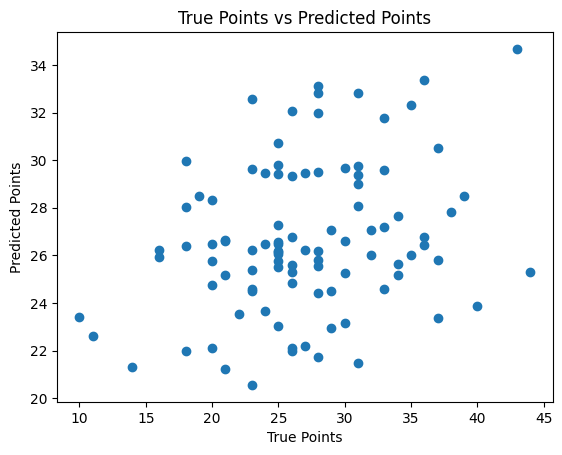

In [271]:
#plot the y predicted vs y test
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('True Points')
plt.ylabel('Predicted Points')
plt.title('True Points vs Predicted Points')
plt.show()


In [273]:
#Now we can start to build our model XG Boost and KNeighbors Regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import statsmodels.tsa.arima.model as arima

numerical_LeStats = pd.read_csv('Weighted_LeStats.csv')
print(len(numerical_LeStats))
#drop any rows with NaN values
numerical_LeStats = numerical_LeStats.dropna()

X = numerical_LeStats.drop(columns=['statistics.points'])
y = numerical_LeStats['statistics.points']




#KNeighbors Regression
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print(knn_score)

#XGBoost Regression
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)

xgb_score = xgb_reg.score(X_test, y_test)

print(xgb_score)

#Random Forest Regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print(rf_score)

484
-0.23039154504277803
-0.1574854850769043
-0.010139962003019587


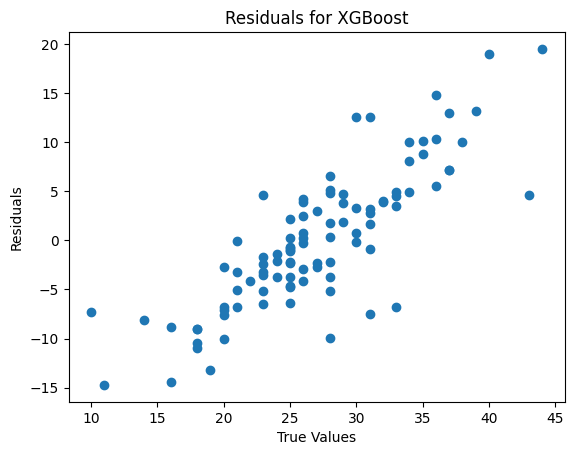

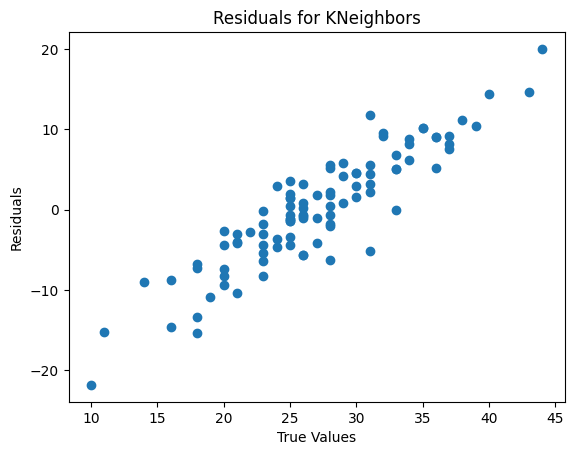

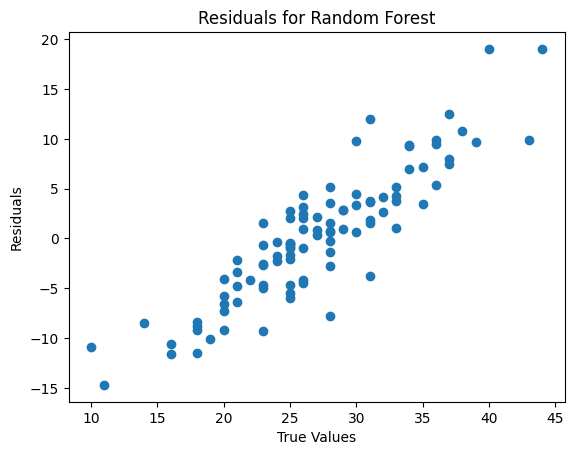

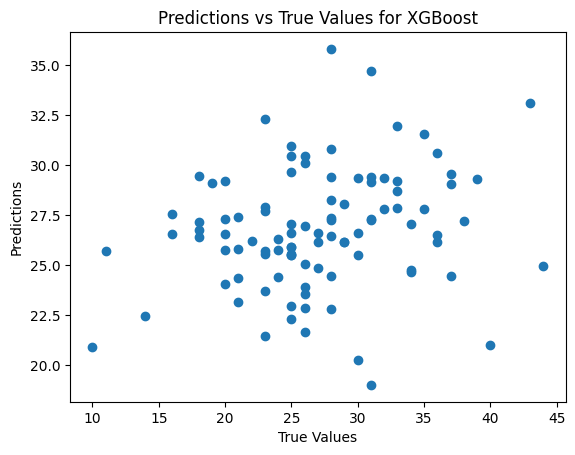

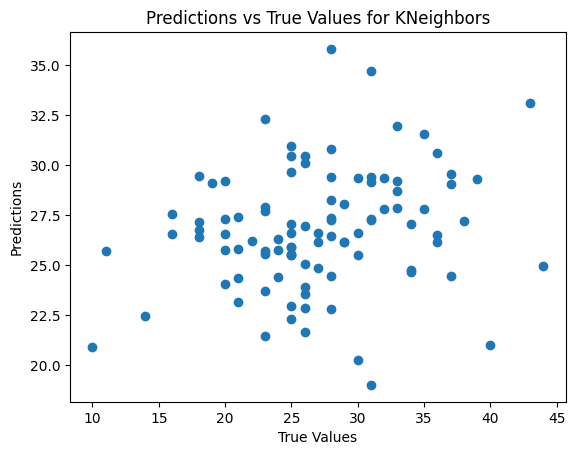

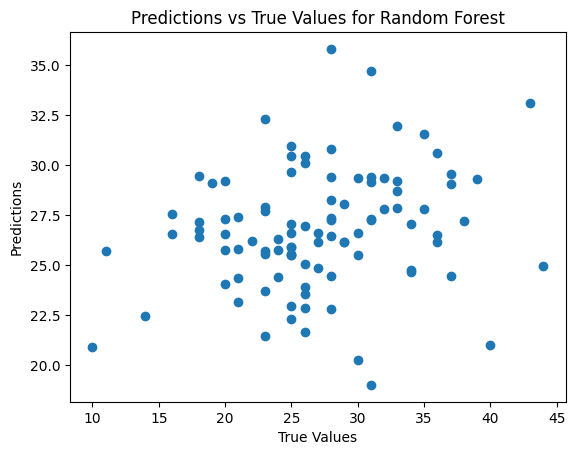

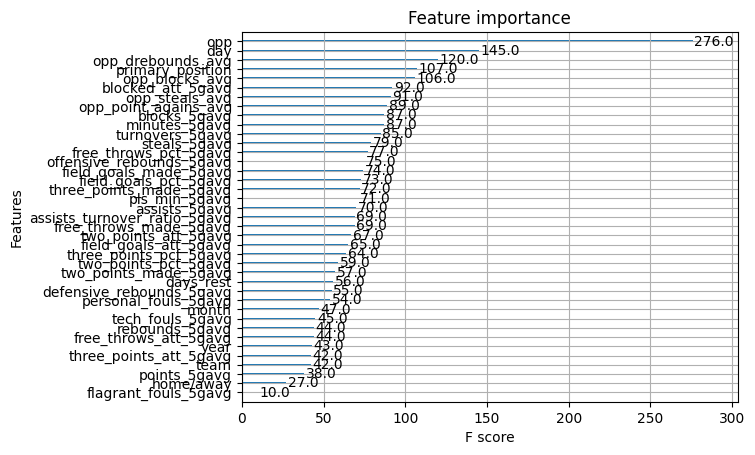

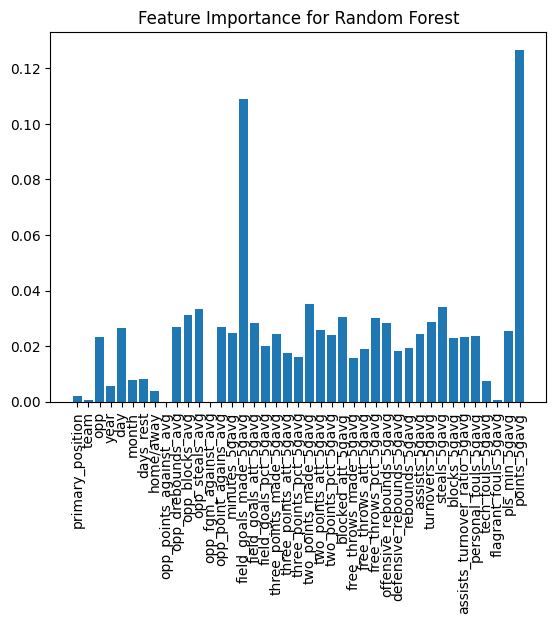

In [274]:
import matplotlib.pyplot as plt
#plot of residuals for XGBoost
y_pred = xgb_reg.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals for XGBoost')
plt.show()

#plot of residuals for KNeighbors
y_pred = knn.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals for KNeighbors')
plt.show()

#plot of residuals for Random Forest
y_pred = rf.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals for Random Forest')
plt.show()

#Plot predictions vs true values for XGBoost
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values for XGBoost')
plt.show()

#Plot predictions vs true values for KNeighbors
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values for KNeighbors')
plt.show()

#Plot predictions vs true values for Random Forest
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values for Random Forest')
plt.show()

#Feature Importance for XGBoost
xgb.plot_importance(xgb_reg)
plt.show()

#Feature Importance for Random Forest
importances = rf.feature_importances_
plt.bar(X.columns, importances)
plt.xticks(rotation=90)
plt.title('Feature Importance for Random Forest')
plt.show()



In [275]:
#list top 20 features for XGBoost
feature_importance = xgb_reg.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame(features, columns=['features'])
feature_importance_df['importance'] = feature_importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df.head(20))

#list top 20 features for Random Forest
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame(features, columns=['features'])
feature_importance_df['importance'] = importances
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df.head(20))



                    features  importance
40              points_5gavg    0.227011
15    field_goals_made_5gavg    0.103415
23      two_points_pct_5gavg    0.034977
36      personal_fouls_5gavg    0.034517
18   three_points_made_5gavg    0.033542
19    three_points_att_5gavg    0.032625
16     field_goals_att_5gavg    0.030671
10            opp_blocks_avg    0.028928
34              blocks_5gavg    0.028839
31             assists_5gavg    0.027485
32           turnovers_5gavg    0.027014
7                  home/away    0.025391
39             pls_min_5gavg    0.024540
26     free_throws_att_5gavg    0.024073
11            opp_steals_avg    0.024064
27     free_throws_pct_5gavg    0.020745
28  offensive_rebounds_5gavg    0.020139
25    free_throws_made_5gavg    0.019975
14             minutes_5gavg    0.019598
37          tech_fouls_5gavg    0.019409
                    features  importance
40              points_5gavg    0.126733
15    field_goals_made_5gavg    0.108994
21     two_point

In [289]:
#try forward seqeuntial selection and backward sequential selection on XGBoost and Random Forest
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
print(len(LeStats.columns))

X = numerical_LeStats.drop(columns=['statistics.points'])
y = numerical_LeStats['statistics.points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

42
['primary_position' 'team' 'opp' 'year' 'day' 'month' 'days_rest'
 'home/away' 'opp_points_against_avg' 'opp_drebounds_avg' 'opp_blocks_avg'
 'opp_steals_avg' 'opp_fgm_against_avg' 'opp_point_agains_avg'
 'minutes_5gavg' 'field_goals_made_5gavg' 'field_goals_att_5gavg'
 'field_goals_pct_5gavg' 'three_points_made_5gavg'
 'three_points_att_5gavg' 'three_points_pct_5gavg' 'two_points_made_5gavg'
 'two_points_att_5gavg' 'two_points_pct_5gavg' 'blocked_att_5gavg'
 'free_throws_made_5gavg' 'free_throws_att_5gavg' 'free_throws_pct_5gavg'
 'offensive_rebounds_5gavg' 'defensive_rebounds_5gavg' 'rebounds_5gavg'
 'assists_5gavg' 'turnovers_5gavg' 'steals_5gavg' 'blocks_5gavg'
 'assists_turnover_ratio_5gavg' 'personal_fouls_5gavg' 'tech_fouls_5gavg'
 'flagrant_fouls_5gavg' 'pls_min_5gavg' 'points_5gavg']


41

In [292]:
#Random Forest
rf = RandomForestRegressor()
sfs = SFS(rf, n_features_to_select=20)
sfs.fit(X_train, y_train)
sfs.fit(X_train, y_train)
print(sfs.feature_names_in_)
print(len(sfs.feature_names_in_))


['primary_position' 'team' 'opp' 'year' 'day' 'month' 'days_rest'
 'home/away' 'opp_points_against_avg' 'opp_drebounds_avg' 'opp_blocks_avg'
 'opp_steals_avg' 'opp_fgm_against_avg' 'opp_point_agains_avg'
 'minutes_5gavg' 'field_goals_made_5gavg' 'field_goals_att_5gavg'
 'field_goals_pct_5gavg' 'three_points_made_5gavg'
 'three_points_att_5gavg' 'three_points_pct_5gavg' 'two_points_made_5gavg'
 'two_points_att_5gavg' 'two_points_pct_5gavg' 'blocked_att_5gavg'
 'free_throws_made_5gavg' 'free_throws_att_5gavg' 'free_throws_pct_5gavg'
 'offensive_rebounds_5gavg' 'defensive_rebounds_5gavg' 'rebounds_5gavg'
 'assists_5gavg' 'turnovers_5gavg' 'steals_5gavg' 'blocks_5gavg'
 'assists_turnover_ratio_5gavg' 'personal_fouls_5gavg' 'tech_fouls_5gavg'
 'flagrant_fouls_5gavg' 'pls_min_5gavg' 'points_5gavg']
41


In [ ]:
#train with the top 20 features but replace minus_5gavg with pls_min_5gavg
top_20_features = feature_importance_df['features'].head(20).tolist()
top_20_features.append('pls_min_5gavg')
top_20_features.remove('minus_5gavg')
X = numerical_LeStats[top_20_features]
y = numerical_LeStats['statistics.points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

xgb_reg.fit(X_train, y_train)

xgb_score = xgb_reg.score(X_test, y_test)

print(xgb_score)

#train Random Forest with top 20 features
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print(rf_score)


In [ ]:
#plot of residuals for XGBoost
y_pred = xgb_reg.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals for XGBoost')
plt.show()

#Plot predictions vs true values for XGBoost
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values for XGBoost')
plt.show()

#Feature Importance for XGBoost
xgb.plot_importance(xgb_reg)
plt.show()



At this point it seems like using an XG Boost will prove most effective, there may be a need for additional features in the context of opponent

In [ ]:
#Using Recursive Feature Selection for XGBoost
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

sffs = SFS(xgb_reg, 
           k_features=25, 
           forward=True, 
           floating=False, 
           scoring='r2',
           cv=0)

#train test split
X = numerical_LeStats.drop(columns=['statistics.points'])
y = numerical_LeStats['statistics.points']

sffs.fit(X_train, y_train)
print(sffs.k_feature_names_)
print(sffs.k_score_)



print(sffs.k_feature_idx_)

